In [627]:
#IMPORT LIBRARY
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import math
import tensorflow as tf
import random

from math import exp

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

from tensorflow import keras
from keras import layers
from keras.layers import Dense

In [628]:
#DATA UNDERSTANDING
data_dir = '/Users/macbookair/Documents/Proyek Informatika /JST-Backpropagation-Backup/datasets/dataipm.csv'
#global variabel intialization
train_ratio = 0.8
epochs = 1000
batch_size = 50
lr = 0.0001
atr_amounts = 5
neurons = 9
activation = 'sigmoid'
#optimizer
#opt = tf.keras.optimizers.experimental.SGD(learning_rate=lr)

In [629]:
df = pd.read_csv(data_dir)
df.head(10)

,Tahun,Data
0,1996,65.07
1,1997,64.08
2,1998,64.08
3,1999,63.09
4,2000,63.58
5,2001,63.58
6,2002,64.07
7,2003,65.08
8,2004,66.09
9,2005,67.06


In [630]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tahun   27 non-null     int64  
 1   Data    27 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 560.0 bytes


In [631]:
df.describe()

,Tahun,Data
count,27.000000,27.000000
mean,2009.000000,66.023704
std,7.937254,2.244076
min,1996.000000,62.050000
25%,2002.500000,64.080000
50%,2009.000000,66.090000
75%,2015.500000,68.150000
max,2022.000000,70.010000


In [632]:
# convert an array of values into a dataset matrix
def create_dataset(arr, look_back=1):
  data = []
  for e in range(len(arr)):
    lookback_data = arr[e:look_back+e]
    if len(lookback_data) == look_back:
      data.append(arr[e:look_back+e])
  columns = ["x"+str(i) for i in range(1,look_back)]
  columns.append("y")
  return pd.DataFrame(data, columns=columns)

In [633]:
timeseries_df = create_dataset(df["Data"].values, 6)
timeseries_df.tail()

,x1,x2,x3,x4,x5,y
17,64.57,66.09,66.04,66.19,66.89,67.81
18,66.09,66.04,66.19,66.89,67.81,68.27
19,66.04,66.19,66.89,67.81,68.27,68.22
20,66.19,66.89,67.81,68.27,68.22,68.43
21,66.89,67.81,68.27,68.22,68.43,68.89


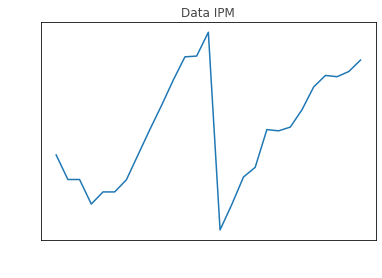

In [634]:
#Grafik dataset real
df.set_index("Tahun", inplace=True)
plt.plot(df)
plt.title("Data IPM")
plt.xlabel("Tahun")
plt.ylabel("Data")
plt.show()

In [635]:
#DATA PREPARATION

#Normalisasi dengan MinMax
minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
minmax_scaled = minmax_scaler.fit_transform(np.array(df))
scaled_data = minmax_scaled

In [636]:
scaled_data

array([[0.37939698],
       [0.25502513],
       [0.25502513],
       [0.13065327],
       [0.19221106],
       [0.19221106],
       [0.25376884],
       [0.38065327],
       [0.50753769],
       [0.62939698],
       [0.75753769],
       [0.87562814],
       [0.87939698],
       [1.        ],
       [0.        ],
       [0.1281407 ],
       [0.26758794],
       [0.31658291],
       [0.50753769],
       [0.50125628],
       [0.5201005 ],
       [0.6080402 ],
       [0.72361809],
       [0.78140704],
       [0.77512563],
       [0.80150754],
       [0.85929648]])

In [637]:
X = timeseries_df.drop(["y"],axis=1).values
y = timeseries_df["y"].values.reshape(-1,1)

In [638]:
X_scaled = minmax_scaler.fit_transform(X)
y_scaled = minmax_scaler.fit_transform(y)

In [639]:
print(X_scaled)

[[0.37939698 0.25502513 0.25502513 0.13065327 0.19221106]
 [0.25502513 0.25502513 0.13065327 0.19221106 0.19221106]
 [0.25502513 0.13065327 0.19221106 0.19221106 0.25376884]
 [0.13065327 0.19221106 0.19221106 0.25376884 0.38065327]
 [0.19221106 0.19221106 0.25376884 0.38065327 0.50753769]
 [0.19221106 0.25376884 0.38065327 0.50753769 0.62939698]
 [0.25376884 0.38065327 0.50753769 0.62939698 0.75753769]
 [0.38065327 0.50753769 0.62939698 0.75753769 0.87562814]
 [0.50753769 0.62939698 0.75753769 0.87562814 0.87939698]
 [0.62939698 0.75753769 0.87562814 0.87939698 1.        ]
 [0.75753769 0.87562814 0.87939698 1.         0.        ]
 [0.87562814 0.87939698 1.         0.         0.1281407 ]
 [0.87939698 1.         0.         0.1281407  0.26758794]
 [1.         0.         0.1281407  0.26758794 0.31658291]
 [0.         0.1281407  0.26758794 0.31658291 0.50753769]
 [0.1281407  0.26758794 0.31658291 0.50753769 0.50125628]
 [0.26758794 0.31658291 0.50753769 0.50125628 0.5201005 ]
 [0.31658291 0

In [640]:
#Preparing Train Data

#Length of Train Data
len_datatrain= math.ceil(len(df)* train_ratio)

#Train data to be scaled process
train_data = scaled_data[0:len_datatrain, :]

#Splitting for training data
X_train = [] #1D list
y_train = []
for i in range(atr_amounts, len(train_data)):
  X_train.append(train_data[i - atr_amounts: i,0])
  y_train.append(train_data[i, 0])

#Coverting x & y train to be arrays in numpy
X_train, y_train = np.array(X_train), np.array(y_train)

#Scaling data for backprop
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #X_train is a one dimensional list
# y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
# X_train = X_train.reshape(((X_train.shape + (1,))))
#y_train = y_train.reshape(((y_train.shape + (1,))))

In [641]:
X_train.shape

(17, 5)

In [642]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #X_train is a one dimensional list

In [643]:
test_data = scaled_data[len_datatrain - atr_amounts:, :]

#Splitting for Data test
X_test = []
y_test = df.iloc[len_datatrain:, :]
for i in range(atr_amounts, len(test_data)):
  X_test.append(test_data[i-atr_amounts:i,0])

#Converting X_test to be array in numpy
X_test = np.array(X_test)

#Scaling data
# X_test = np.reshape(X_test, (X_test.shape + (1,)))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [644]:
#MODELING
from keras import backend as K
def mean_squared_error(y_actual, y_pred):
    return K.mean(K.square(y_pred - y_actual), axis=-1)

def mse(actual, predicted):
    actual = np.array(actual, dtype="float64")
    predicted = np.array(predicted, dtype="float64")
    differences = np.subtract(actual, predicted)
    squared_differences = np.square(differences)
    return squared_differences.mean()

def mape(actual, pred): 
    actual = np.array(actual, dtype="float64")
    pred = np.array(pred, dtype="float64")
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [646]:
#Architecture Model Backpropogation
#digunakan untuk intinya hasilnya ga berubah berubah
random.seed(10)
tf.random.set_seed(10)

#kernel initializer digunakan untuk inisialisasi bobot
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(neurons, input_shape=(atr_amounts,), activation=activation),
        tf.keras.layers.Dense(1)])


#Compiling Models
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=["MAE"]) #matriks to evaluate model 

#Training Model
history = model.fit(X_train,
                    y_train,
                    verbose=1,
                    epochs=10,
                    batch_size=32)


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.8648 - MAE: 0.8915
Epoch 2/10
1/1 [==============================] - 0s 33ms/step - loss: 0.8505 - MAE: 0.8834
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 0.8363 - MAE: 0.8753
Epoch 4/10
1/1 [==============================] - 0s 21ms/step - loss: 0.8222 - MAE: 0.8672
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 0.8083 - MAE: 0.8592
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: 0.7946 - MAE: 0.8511
Epoch 7/10
1/1 [==============================] - 0s 30ms/step - loss: 0.7810 - MAE: 0.8430
Epoch 8/10
1/1 [==============================] - 0s 23ms/step - loss: 0.7675 - MAE: 0.8350
Epoch 9/10
1/1 [==============================] - 0s 23ms/step - loss: 0.7542 - MAE: 0.8270
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 0.7411 - MAE: 0.8190


In [651]:
#MODEL EVALUATION
#Predict HDI 
pred = model.predict(X_test)
pred = minmax_scaler.inverse_transform(pred) #Undo Scalling
pred

1/1 [==============================] - 0s 60ms/step


array([[59.850037],
       [60.026268],
       [60.39563 ],
       [60.63884 ],
       [60.626453]], dtype=float32)

In [652]:

# Evaluate the performance of the model
# loss = model.evaluate(test_data[:, :3], test_data[:, 3:])
loss = model.evaluate(X_test, y_test)
print("Loss on testing set:", loss)

1/1 [==============================] - 0s 47ms/step - loss: 4698.2314 - MAE: 68.5429
Loss on testing set: [4698.2314453125, 68.54291534423828]


In [653]:
mse(np.array(y_test), pred)

64.30585656440607

In [654]:
y_test

,Data
Tahun,
2018,67.81
2019,68.27
2020,68.22
2021,68.43
2022,68.89


/var/folders/0h/5wc5zkn126g3bxj_gr_hf8f40000gn/T/ipykernel_1325/1331281217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Prediction"] = pred
/var/folders/0h/5wc5zkn126g3bxj_gr_hf8f40000gn/T/ipykernel_1325/1331281217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['MSE'] = mean_squared_error(y_test, pred)


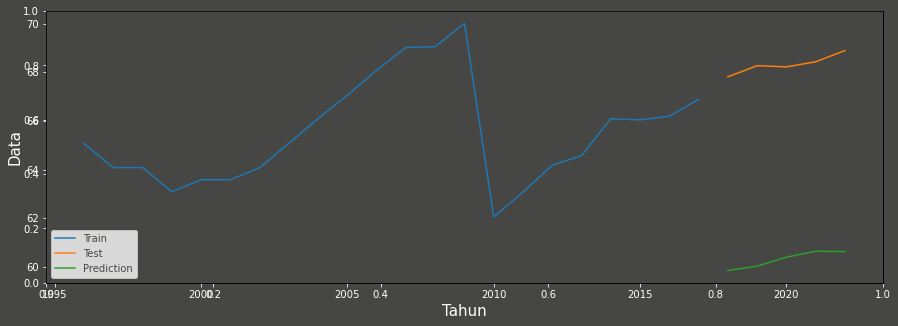

In [656]:
#Plotting Prediction Values

train = df[:len_datatrain] #train set
valid = df[len_datatrain:] #test set
valid["Prediction"] = pred
valid['MSE'] = mean_squared_error(y_test, pred) 

#Graph Predict
plt.figure(figsize=(15,5), facecolor='#464745')
plt.xlabel('Tahun', fontsize=15)
ax = plt.axes()
ax.set_facecolor('#464745')
plt.ylabel('Data', fontsize=15)
plt.plot(train['Data'])
plt.plot(valid[['Data', 'Prediction']])
plt.legend(['Train', 'Test', 'Prediction'], loc='lower left')
plt.rcParams.update({
    'text.color': '#464745',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
    })
plt.savefig('res_tmp.png', transparent=True)
plt.show()

In [657]:
valid

,Data,Prediction,MSE
Tahun,,,
2018,67.81,59.850037,63.361017
2019,68.27,60.026268,67.959117
2020,68.22,60.395630,61.220768
2021,68.43,60.638840,60.702178
2022,68.89,60.626453,68.286202


In [658]:
#MAPE and Accuracy
mape = mape(y_test, pred)   #validation
acc = round(100 - mape, 3)
print('MAPE \t\t=' + str(mape) + '%') 
print('Accuracy \t=' + str(acc) + '%') #akurasi testing

MAPE 		=11.732801245076029%
Accuracy 	=88.267%


In [659]:
#PREDICT HDI'S FUTURE

len(X_test)

5

In [660]:
updated_data = []
for i in range(0, len(X_test[-1])):
  if i == 0:
    pass
  else:
    updated_data.append(X_test[-1][i])
updated_data.append([0])
updated_data = np.array(updated_data)

In [661]:
X_test = np.append(X_test, [updated_data], axis=0)
X_test = np.asarray(X_test).astype(np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

updated_pred = model.predict(X_test)
updated_pred = minmax_scaler.inverse_transform(updated_pred) 

1/1 [==============================] - 0s 74ms/step


In [662]:
#Reading the result data after upgrading process on prediction using data testing
rest_predict = updated_pred[-1]
rest_predict

array([60.337734], dtype=float32)